Initial working directory: /workspace/Score-Entropy-Discrete-Diffusion


Token indices sequence length is longer than the specified maximum sequence length for this model (1123 > 1024). Running this sequence through the model will result in indexing errors


GPT-2 토크나이저 로드 완료.
EOS token: '<|endoftext|>', ID: 50256
PAD token: '<|endoftext|>', ID: 50256

'sampledata/processed_dataset.csv' 파일 로드 완료. Shape: (123, 2)

데이터 샘플 (상위 3개):
                                        conditioning  \
0  Order information\n• item15, right? 318? You c...   
1  Order information\n• Oh, I just got the item16...   
2  Order information\n• There, I need to do 19 dr...   

                                               order  
0  • item87 machine01 date169 17\n• item87 machin...  
1  • item87 machine03 date169 53\n• item87 machin...  
2  • item87 machine01 date169 71\n• item87 machin...  

각 샘플 토큰화 진행 중 (구분자: '<|endoftext|>')...

--- 샘플 1 ---
Conditioning Text (일부): 'Order information
• item15, right? 318? You can do it by May 13th, 2021, and the unit price is 25,87...' (토큰 수: 772)
Order Text (일부): '• item87 machine01 date169 17
• item87 machine03 date169 63
• item87 machine18 date169 21
• item87 m...' (토큰 수: 350)
Combined Text (일부): 'Order information
• item15, 

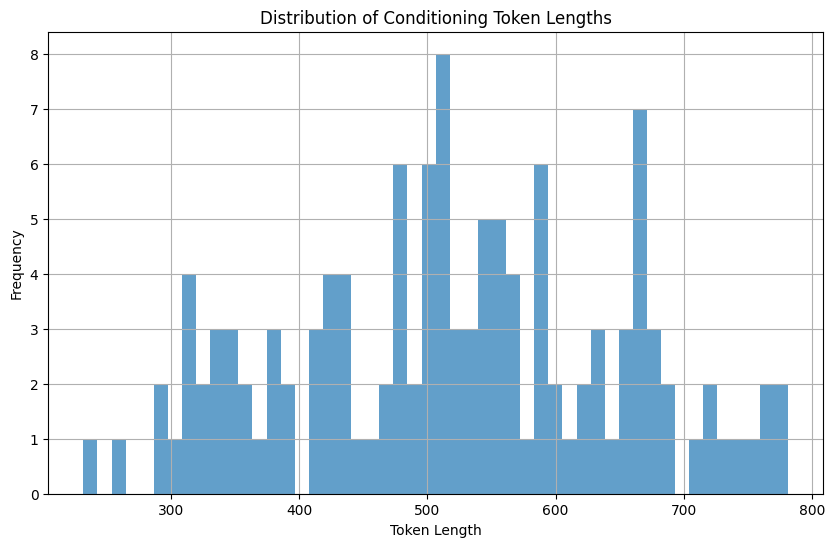


--- 'Order (GT)' 토큰 길이 통계 ---
총 분석된 샘플 수: 123
최소 토큰 길이: 37
최대 토큰 길이: 512
평균 토큰 길이: 213.90
중앙값 토큰 길이: 215.0
90 백분위수: 364.40
95 백분위수: 386.00
99 백분위수: 483.02


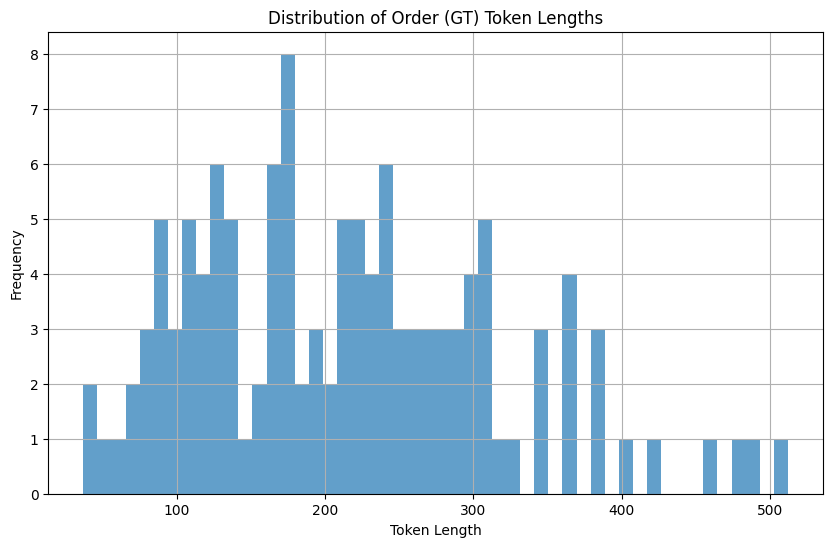


--- 'Combined (Conditioning + SEP + Order)' 토큰 길이 통계 ---
총 분석된 샘플 수: 123
최소 토큰 길이: 270
최대 토큰 길이: 1258
평균 토큰 길이: 734.85
중앙값 토큰 길이: 745.0
90 백분위수: 1011.40
95 백분위수: 1103.30
99 백분위수: 1147.56


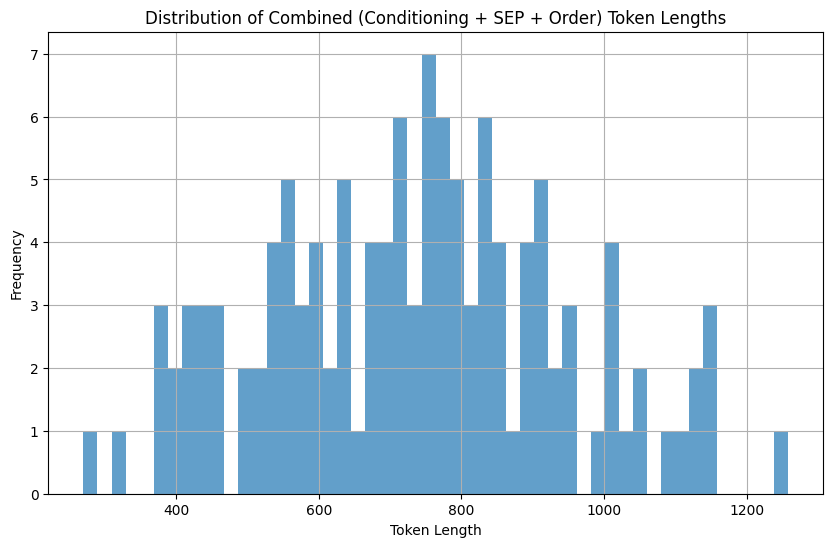

In [4]:
# 새로운 ipynb 파일의 첫 번째 셀들

# 필요한 라이브러리 임포트
import sys
import os
import pandas as pd
import numpy as np
import torch
from transformers import GPT2TokenizerFast
import matplotlib.pyplot as plt # 히스토그램용

# --- 경로 설정 및 기본 객체 로드 (필요시) ---
# 이 부분은 이전 노트북에서 모델 로드까지 성공했으므로,
# 여기서는 토크나이저만 새로 로드하거나, 필요시 이전 객체를 활용할 수 있습니다.
# 간단하게 토크나이저만 다시 로드하는 것으로 진행합니다.

print(f"Initial working directory: {os.getcwd()}")
# SEDD 레포지토리 루트로 작업 디렉토리 변경 (필요시 경로 수정)
repo_path = '/workspace/Score-Entropy-Discrete-Diffusion' # 사용자 환경에 맞게 수정
if os.path.exists(repo_path) and os.path.isdir(repo_path) and os.getcwd() != repo_path:
    os.chdir(repo_path)
    print(f"Changed working directory to: {os.getcwd()}")
sys.path.append(os.getcwd())


# --- 토크나이저 로드 ---
try:
    tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token # PAD 토큰 설정
    print("GPT-2 토크나이저 로드 완료.")
    print(f"EOS token: '{tokenizer.eos_token}', ID: {tokenizer.eos_token_id}")
    print(f"PAD token: '{tokenizer.pad_token}', ID: {tokenizer.pad_token_id}")
except Exception as e:
    print(f"토크나이저 로드 중 오류 발생: {e}")
    tokenizer = None

# --- 데이터 파일 경로 ---
data_file_path = 'sampledata/processed_dataset.csv' # 실제 파인튜닝 시 전체 파일명으로 변경

# --- 데이터 로드 ---
try:
    df_processed_data = pd.read_csv(data_file_path)
    print(f"\n'{data_file_path}' 파일 로드 완료. Shape: {df_processed_data.shape}")
    print("\n데이터 샘플 (상위 3개):")
    print(df_processed_data.head(3))
except FileNotFoundError:
    print(f"Error: CSV 파일을 찾을 수 없습니다. 경로를 확인하세요: {data_file_path}")
    df_processed_data = pd.DataFrame()
except Exception as e:
    print(f"데이터 로드 중 오류 발생: {e}")
    df_processed_data = pd.DataFrame()

# --- 토큰 길이 분석 ---
if not df_processed_data.empty and tokenizer:
    token_lengths_conditioning = []
    token_lengths_order = []
    token_lengths_combined = []
    
    sep_token_str = tokenizer.eos_token 

    print(f"\n각 샘플 토큰화 진행 중 (구분자: '{sep_token_str}')...")
    for index, row in df_processed_data.iterrows():
        conditioning_text = str(row['conditioning'])
        order_text = str(row['order']) # 컬럼명이 'output'에서 'order'로 변경된 것을 반영
        
        combined_text = conditioning_text + sep_token_str + order_text
        
        tokens_conditioning = tokenizer(conditioning_text, add_special_tokens=False)['input_ids']
        tokens_order = tokenizer(order_text, add_special_tokens=False)['input_ids']
        tokens_combined = tokenizer(combined_text, add_special_tokens=False)['input_ids']
        
        token_lengths_conditioning.append(len(tokens_conditioning))
        token_lengths_order.append(len(tokens_order))
        token_lengths_combined.append(len(tokens_combined))
        
        if index < 2: # 처음 2개 샘플에 대해서만 상세 정보 출력
            print(f"\n--- 샘플 {index+1} ---")
            print(f"Conditioning Text (일부): '{conditioning_text[:100]}...' (토큰 수: {len(tokens_conditioning)})")
            print(f"Order Text (일부): '{order_text[:100]}...' (토큰 수: {len(tokens_order)})")
            print(f"Combined Text (일부): '{combined_text[:150]}...' (토큰 수: {len(tokens_combined)})")
            print(f"토큰화된 Combined (처음 10개): {tokens_combined[:10]}")
            print(f"디코딩된 Combined (처음 10개): {[tokenizer.decode([tid]) for tid in tokens_combined[:10]]}")


    def print_token_stats(lengths, name):
        if lengths:
            print(f"\n--- '{name}' 토큰 길이 통계 ---")
            print(f"총 분석된 샘플 수: {len(lengths)}")
            print(f"최소 토큰 길이: {np.min(lengths)}")
            print(f"최대 토큰 길이: {np.max(lengths)}")
            print(f"평균 토큰 길이: {np.mean(lengths):.2f}")
            print(f"중앙값 토큰 길이: {np.median(lengths)}")
            print(f"90 백분위수: {np.percentile(lengths, 90):.2f}")
            print(f"95 백분위수: {np.percentile(lengths, 95):.2f}")
            print(f"99 백분위수: {np.percentile(lengths, 99):.2f}")
            
            plt.figure(figsize=(10, 6))
            plt.hist(lengths, bins=50, alpha=0.7)
            plt.title(f'Distribution of {name} Token Lengths')
            plt.xlabel('Token Length')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()
        else:
            print(f"'{name}'에 대한 토큰 길이를 분석할 데이터가 없습니다.")

    print_token_stats(token_lengths_conditioning, "Conditioning")
    print_token_stats(token_lengths_order, "Order (GT)")
    print_token_stats(token_lengths_combined, "Combined (Conditioning + SEP + Order)")

else:
    if df_processed_data.empty:
        print(f"오류: '{data_file_path}' 파일이 비어 있거나 로드되지 않았습니다.")
    if not tokenizer:
        print("오류: 토크나이저가 성공적으로 로드되지 않아 분석을 진행할 수 없습니다.")

In [5]:
# 새로운 ipynb 파일의 파인튜닝 코드 셀들

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os
import json
from transformers import GPT2TokenizerFast # 명시적으로 임포트

# SEDD 레포지토리의 유틸리티 함수 임포트
# 경로 설정 (이 ipynb 파일이 Score-Entropy-Discrete-Diffusion 폴더 내에 있다고 가정)
print(f"Initial working directory: {os.getcwd()}")
if not os.path.basename(os.getcwd()) == 'Score-Entropy-Discrete-Diffusion':
    repo_path = '/workspace/Score-Entropy-Discrete-Diffusion' # 사용자 환경에 맞게 수정
    if os.path.exists(repo_path) and os.path.isdir(repo_path):
        os.chdir(repo_path)
        print(f"Changed working directory to: {os.getcwd()}")
    else:
        print(f"Warning: Repository path '{repo_path}' not found. 파이썬 모듈 임포트에 문제가 생길 수 있습니다.")
sys.path.append(os.getcwd()) # 현재 디렉토리를 sys.path에 추가

import losses 
from model import utils as mutils
import sampling
from load_model import load_model # load_model.py 임포트

# --- 전역 변수 및 하이퍼파라미터 ---
DATA_FILE_PATH = 'sampledata/processed_dataset.csv'
MODEL_SAVE_DIR = '100epoch_finetuned_sedd_model'
MAX_SEQ_LENGTH = 1024
LEARNING_RATE = 5e-5
NUM_EPOCHS = 100
BATCH_SIZE = 4 # A100 80GB에서 이 값은 더 늘릴 수 있습니다. 우선 테스트용.
ACCUMULATION_STEPS = 4

SAVE_EVERY_N_STEPS = 100
LOG_EVERY_N_STEPS = 10

# --- 장치 설정 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 토크나이저 로드 ---
try:
    tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    print("GPT-2 토크나이저 로드 완료.")
    SEP_TOKEN = tokenizer.eos_token # 구분자 설정
    print(f"EOS/SEP token: '{SEP_TOKEN}', ID: {tokenizer.eos_token_id}")
    print(f"PAD token: '{tokenizer.pad_token}', ID: {tokenizer.pad_token_id}")
except Exception as e:
    print(f"토크나이저 로드 중 오류 발생: {e}")
    tokenizer = None
    SEP_TOKEN = "<|endoftext|>" # Fallback

# --- 모델 로드 ---
if tokenizer: # 토크나이저 로드가 성공했을 경우에만 모델 로드 시도
    try:
        model_path_load = "louaaron/sedd-small" # HuggingFace Hub 모델 경로
        print(f"Loading model from: {model_path_load}")
        score_model, graph, noise = load_model(model_path_load, device)
        print("SEDD 모델, graph, noise 객체 로드 완료.")
    except Exception as e:
        print(f"SEDD 모델 로드 중 오류 발생: {e}")
        score_model, graph, noise = None, None, None
else:
    print("토크나이저 로드 실패로 모델 로드를 진행하지 않습니다.")
    score_model, graph, noise = None, None, None


# --- 데이터셋 클래스 정의 ---
class ProductionPlanningDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_total_len, sep_token):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_total_len = max_total_len # 전체 합쳐진 시퀀스의 최대 길이 (예: 1024)
        self.sep_token = sep_token
        self.sep_token_id = tokenizer.encode(sep_token, add_special_tokens=False)[0] # SEP 토큰 ID
        # BOS/EOS 토큰 ID (add_special_tokens=True 시 사용될 수 있음)
        self.bos_token_id = tokenizer.bos_token_id if tokenizer.bos_token_id is not None else self.sep_token_id # BOS 없으면 SEP으로 대체(임시)
        self.eos_token_id = tokenizer.eos_token_id if tokenizer.eos_token_id is not None else self.sep_token_id # EOS 없으면 SEP으로 대체(임시)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        conditioning_text = str(row['conditioning'])
        order_text = str(row['order'])

        # 1. 각 부분을 개별적으로 토큰화 (아직 패딩/트렁케이션 안함, 특수토큰도 미포함)
        conditioning_tokens = self.tokenizer.encode(conditioning_text, add_special_tokens=False)
        order_tokens = self.tokenizer.encode(order_text, add_special_tokens=False)

        # 2. 길이 계산 및 할당
        # 모델 입력은 [BOS] conditioning_tokens [SEP] order_tokens [EOS] 형태를 가정 (add_special_tokens=True 시)
        # 또는 [conditioning_tokens [SEP] order_tokens] 형태로 하고 나중에 일괄 BOS/EOS 추가도 가능
        # 여기서는 각 파트의 순수 토큰 길이를 기준으로 하고, 최종적으로 합칠 때 특수 토큰 고려
        
        # conditioning은 최대한 보존. SEP 토큰 1개 자리는 확보.
        # 실제 모델 입력으로 들어갈 때는 BOS, EOS 토큰 2개가 더 필요할 수 있으므로,
        # max_total_len에서 3개 (BOS, SEP, EOS) 자리를 우선 빼고 계산하는 것이 안전.
        # (단, tokenizer.encode_plus에서 add_special_tokens=True가 어떻게 작동하는지 정확히 봐야함)
        # 우선 간단하게는 SEP 1개만 고려.
        
        available_len_for_cond_and_order = self.max_total_len - 1 # SEP 토큰 1개 자리 제외
        
        # Conditioning 토큰 처리
        if len(conditioning_tokens) > available_len_for_cond_and_order:
            # Conditioning이 너무 길어서 order를 위한 공간이 아예 없는 경우
            # (이런 경우는 데이터 전처리 단계에서 걸러지거나, 다른 처리 필요)
            # 여기서는 conditioning을 자름 (원래는 안 자르기로 했지만, order 공간이 아예 없으면 안되므로)
            print(f"Warning: 샘플 {index}의 Conditioning이 너무 길어 일부 잘립니다. (원본: {len(conditioning_tokens)} -> 최대: {available_len_for_cond_and_order})")
            conditioning_tokens_final = conditioning_tokens[:available_len_for_cond_and_order]
            order_tokens_final = [] # order 공간 없음
        else:
            conditioning_tokens_final = conditioning_tokens
            
        # Order 토큰 처리 (남은 공간에 맞춰)
        remaining_len_for_order = available_len_for_cond_and_order - len(conditioning_tokens_final)
        if len(order_tokens) > remaining_len_for_order:
            order_tokens_final = order_tokens[:remaining_len_for_order] # order 뒷부분 잘림
        else:
            order_tokens_final = order_tokens
            
        # 3. 최종 입력 시퀀스 생성 (conditioning + SEP + order)
        # 이 시퀀스가 x_0 (오염 대상)가 되고, 모델의 입력으로도 사용됨 (오염 후)
        # 패딩은 DataLoader에서 일괄적으로 하거나, 여기서 직접 할 수도 있음.
        # SEDD의 학습 방식은 패딩된 부분의 loss를 무시하는 메커니즘이 명시적으로 필요할 수 있음.
        # 우선은 input_ids와 conditioning_len을 반환하는 데 집중.
        
        input_ids_list = conditioning_tokens_final + [self.sep_token_id] + order_tokens_final
        
        # 실제 conditioning 부분의 길이 (SEP 토큰 포함 전까지)
        conditioning_len = len(conditioning_tokens_final) 
        # 실제 order 부분의 시작 인덱스 (SEP 토큰 다음)
        order_start_idx = conditioning_len + 1 # 0-based index
        
        # 패딩 처리
        num_padding_tokens = self.max_total_len - len(input_ids_list)
        if num_padding_tokens < 0:
            # 이 경우는 위에서 길이 조절이 잘못되었거나, SEP 토큰 등을 고려한 길이가 max_total_len을 초과한 경우
            # print(f"Error: 샘플 {index}의 최종 길이가 max_total_len을 초과합니다. {len(input_ids_list)} > {self.max_total_len}")
            # 임시로 자르기 (가장 마지막 부분)
            input_ids_padded = input_ids_list[:self.max_total_len]
            # 이런 경우 order_start_idx가 max_total_len보다 클 수 있으므로, order_len 계산 시 주의
        else:
            input_ids_padded = input_ids_list + [self.tokenizer.pad_token_id] * num_padding_tokens

        # attention_mask 생성 (패딩된 부분은 0, 아닌 부분은 1)
        attention_mask = [1] * len(input_ids_list) + [0] * num_padding_tokens
        if len(attention_mask) > self.max_total_len: # 잘렸을 경우 mask도 맞춰줌
            attention_mask = attention_mask[:self.max_total_len]

        # order 부분의 실제 길이 (패딩 제외)
        order_len = len(order_tokens_final)

        return {
            'input_ids': torch.tensor(input_ids_padded, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'conditioning_len': conditioning_len, # SEP 토큰 전까지의 길이
            'order_start_idx': order_start_idx,   # SEP 토큰 다음부터 order 시작
            'order_len': order_len                # 실제 order 토큰의 길이 (패딩 제외)
        }
# --- 데이터 로드 및 DataLoader 생성 ---
print(f"데이터 로딩: {DATA_FILE_PATH}")
df_train = pd.read_csv(DATA_FILE_PATH)
print(f"로드된 데이터 shape: {df_train.shape}")

# 수정된 Dataset 사용
train_dataset = ProductionPlanningDataset(df_train, tokenizer, MAX_SEQ_LENGTH, SEP_TOKEN)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) 

print(f"데이터셋 및 데이터로더 준비 완료. 총 샘플 수: {len(train_dataset)}, 총 배치 수: {len(train_dataloader)}")

# --- 모델, 옵티마이저, 손실 함수 설정 ---
if 'score_model' not in globals() or not score_model: # 이전 셀에서 로드 안됐거나 실패했을 경우 대비
    print("모델 객체(score_model 등)가 로드되지 않았습니다. 모델을 로드합니다...")
    try:
        from load_model import load_model as load_model_internal
        model_path_load = "louaaron/sedd-small"
        score_model, graph, noise = load_model_internal(model_path_load, device)
        print("SEDD 모델, graph, noise 객체 로드 완료.")
    except Exception as e:
        print(f"SEDD 모델 로드 중 오류 발생: {e}. 파인튜닝을 진행할 수 없습니다.")
        # 이 경우 스크립트 중단 또는 기본 모델 생성 등의 처리 필요
        raise # 오류 발생 시 중단

score_model.to(device) 
score_model.train()    

optimizer = optim.AdamW(score_model.parameters(), lr=LEARNING_RATE)
# losses.get_loss_fn은 그대로 사용, 다만 loss 계산 방식이 달라짐
loss_fn_sedd_base = losses.get_loss_fn(noise.to(device), graph, train=True) 

print("모델, 옵티마이저, 기본 손실 함수 설정 완료.")


Initial working directory: /workspace/Score-Entropy-Discrete-Diffusion
Using device: cuda
GPT-2 토크나이저 로드 완료.
EOS/SEP token: '<|endoftext|>', ID: 50256
PAD token: '<|endoftext|>', ID: 50256
Loading model from: louaaron/sedd-small
SEDD 모델, graph, noise 객체 로드 완료.
데이터 로딩: sampledata/processed_dataset.csv
로드된 데이터 shape: (123, 2)
데이터셋 및 데이터로더 준비 완료. 총 샘플 수: 123, 총 배치 수: 31
모델, 옵티마이저, 기본 손실 함수 설정 완료.


In [6]:
# --- 수정된 학습 루프 ---
print("\n실제 파인튜닝 학습 루프 시작 (Order 부분 Loss만 사용)...")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
global_step = 0
all_step_losses = [] 
all_epoch_avg_losses = [] 

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    epoch_loss_sum = 0.0 
    num_optimizer_steps_in_epoch = 0 # 실제 optimizer.step()이 호출된 횟수 (로깅용)
    
    optimizer.zero_grad() 

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=False)
    for batch_idx, batch_data in enumerate(progress_bar):
        input_ids_batch = batch_data['input_ids'].to(device) # (B, MAX_SEQ_LENGTH)
        # attention_mask_batch = batch_data['attention_mask'].to(device) # 현재 SEDD loss는 사용 안함
        conditioning_len_batch = batch_data['conditioning_len'].to(device) # (B)
        order_start_idx_batch = batch_data['order_start_idx'].to(device)   # (B)
        order_len_batch = batch_data['order_len'].to(device)               # (B)

        # 1. 오염된 입력 생성 (loss_fn_sedd_base 내부에서 수행됨, x_0는 input_ids_batch)
        #    loss_fn_sedd_base는 전체 시퀀스에 대한 score_entropy를 반환함 (shape: [B, MAX_SEQ_LENGTH])
        #    또는 스칼라 loss를 반환할 경우 (내부적으로 .mean() 등), 아래 로직 수정 필요.
        #    losses.get_loss_fn의 반환값 형태를 다시 한번 확인해야 함.
        #    원본 losses.py의 loss_fn은 (dsigma[:, None] * loss).sum(dim=-1) 이므로, [B] 형태의 loss를 반환.
        #    이 loss는 각 시퀀스 전체에 대한 가중합 loss임.
        #    우리는 "order" 부분만의 loss를 원하므로, score_entropy의 출력을 직접 다뤄야 함.

        # --- Score Entropy를 직접 계산하고 Order 부분만 선택 (losses.py 내부 로직 참고) ---
        # 가. 시간 t 및 sigma 샘플링 (losses.py의 loss_fn 내부와 동일하게)
        t_for_loss = (1 - 1e-3) * torch.rand(input_ids_batch.shape[0], device=device) + 1e-3
        current_sigma, current_dsigma = noise(t_for_loss)

        # 나. Order 부분만 오염 (conditioning은 원본 유지)
        perturbed_input_for_model = torch.clone(input_ids_batch) # 전체 복사 후 order 부분만 수정
        for i in range(input_ids_batch.shape[0]): # 배치 내 각 샘플에 대해
            c_len = conditioning_len_batch[i].item()
            o_start = order_start_idx_batch[i].item()
            o_len = order_len_batch[i].item()
            
            if o_len > 0: # order 부분이 실제로 존재할 때만 오염
                original_order_part = input_ids_batch[i, o_start : o_start + o_len]
                perturbed_order_part = graph.sample_transition(original_order_part.unsqueeze(0), current_sigma[i].unsqueeze(0)).squeeze(0)
                perturbed_input_for_model[i, o_start : o_start + o_len] = perturbed_order_part
        
        # 다. 모델 호출하여 스코어 예측
        log_score_pred = mutils.get_score_fn(score_model, train=True, sampling=False)(perturbed_input_for_model, current_sigma)
        
        # 라. Score Entropy 계산 (graph.score_entropy는 [B, L] 형태의 엔트로피 기여도 반환)
        # input_ids_batch 가 x_0 (원본)
        score_entropy_per_token = graph.score_entropy(log_score_pred, current_sigma[:, None], perturbed_input_for_model, input_ids_batch)
        
        # 마. Order 부분의 Loss만 선택 및 평균 계산
        batch_order_loss_sum = 0.0
        num_actual_order_tokens_in_batch = 0
        for i in range(input_ids_batch.shape[0]):
            o_start = order_start_idx_batch[i].item()
            o_len = order_len_batch[i].item()
            if o_len > 0:
                # dsigma 가중치를 order 부분의 loss에만 적용
                order_loss_for_sample = (current_dsigma[i] * score_entropy_per_token[i, o_start : o_start + o_len]).sum()
                batch_order_loss_sum += order_loss_for_sample
                num_actual_order_tokens_in_batch += o_len # 또는 단순히 o_len.sum()으로 배치 전체 합산 가능
        
        if num_actual_order_tokens_in_batch > 0:
            final_loss = batch_order_loss_sum / num_actual_order_tokens_in_batch # 토큰별 평균 loss
        elif input_ids_batch.shape[0] > 0 : # order 토큰이 없지만 배치가 있다면 loss 0 (또는 다른 처리)
            final_loss = torch.tensor(0.0, device=device, requires_grad=True) # 역전파 가능하도록
        else: # 배치도 없다면 (이 경우는 거의 없음)
             final_loss = torch.tensor(0.0, device=device)


        loss_unscaled = final_loss.item() 
        
        loss_for_backward = final_loss / ACCUMULATION_STEPS
        loss_for_backward.backward()
        
        epoch_loss_sum += loss_unscaled 
        num_optimizer_steps_in_epoch +=1 # epoch_loss_sum에 더해지는 횟수 기준

        if (batch_idx + 1) % ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(train_dataloader):
            torch.nn.utils.clip_grad_norm_(score_model.parameters(), 1.0) 
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
            
            current_avg_loss_so_far_in_epoch = epoch_loss_sum / num_optimizer_steps_in_epoch if num_optimizer_steps_in_epoch > 0 else 0
            all_step_losses.append(current_avg_loss_so_far_in_epoch)

            if global_step % LOG_EVERY_N_STEPS == 0:
                progress_bar.set_postfix(avg_epoch_loss=f"{current_avg_loss_so_far_in_epoch:.4f}", last_batch_loss=f"{loss_unscaled:.4f}")
            
            if global_step % SAVE_EVERY_N_STEPS == 0:
                save_path = os.path.join(MODEL_SAVE_DIR, f"model_step_{global_step}.pt")
                torch.save(score_model.state_dict(), save_path)
                print(f"모델 저장 완료: {save_path} (Step: {global_step}, Avg Epoch Loss: {current_avg_loss_so_far_in_epoch:.4f})")
    
    avg_epoch_loss_final = epoch_loss_sum / len(train_dataloader) if len(train_dataloader) > 0 else 0
    all_epoch_avg_losses.append(avg_epoch_loss_final) 
    print(f"Epoch {epoch+1} 완료. 최종 평균 Loss: {avg_epoch_loss_final:.4f}")
    
    epoch_save_path = os.path.join(MODEL_SAVE_DIR, f"model_epoch_{epoch+1}.pt")
    torch.save(score_model.state_dict(), epoch_save_path)
    print(f"모델 저장 완료 (Epoch {epoch+1}): {epoch_save_path}")

print("\n파인튜닝 학습 루프 종료.")
tokenizer.save_pretrained(MODEL_SAVE_DIR)
print(f"토크나이저 저장 완료: {MODEL_SAVE_DIR}")

# 학습 루프 후 all_step_losses 와 all_epoch_avg_losses 리스트를 다음 셀에서 사용



실제 파인튜닝 학습 루프 시작 (Order 부분 Loss만 사용)...

--- Epoch 1/100 ---


Epoch 1 완료. 최종 평균 Loss: 2.0135
모델 저장 완료 (Epoch 1): 100epoch_finetuned_sedd_model/model_epoch_1.pt

--- Epoch 2/100 ---


Epoch 2 완료. 최종 평균 Loss: 1.4459
모델 저장 완료 (Epoch 2): 100epoch_finetuned_sedd_model/model_epoch_2.pt

--- Epoch 3/100 ---


Epoch 3 완료. 최종 평균 Loss: 1.2588
모델 저장 완료 (Epoch 3): 100epoch_finetuned_sedd_model/model_epoch_3.pt

--- Epoch 4/100 ---


Epoch 4 완료. 최종 평균 Loss: 1.0299
모델 저장 완료 (Epoch 4): 100epoch_finetuned_sedd_model/model_epoch_4.pt

--- Epoch 5/100 ---


Epoch 5 완료. 최종 평균 Loss: 1.1525
모델 저장 완료 (Epoch 5): 100epoch_finetuned_sedd_model/model_epoch_5.pt

--- Epoch 6/100 ---


Epoch 6 완료. 최종 평균 Loss: 1.1008
모델 저장 완료 (Epoch 6): 100epoch_finetuned_sedd_model/model_epoch_6.pt

--- Epoch 7/100 ---


Epoch 7 완료. 최종 평균 Loss: 0.9837
모델 저장 완료 (Epoch 7): 100epoch_finetuned_sedd_model/model_epoch_7.pt

--- Epoch 8/100 ---


Epoch 8 완료. 최종 평균 Loss: 1.0004
모델 저장 완료 (Epoch 8): 100epoch_finetuned_sedd_model/model_epoch_8.pt

--- Epoch 9/100 ---


Epoch 9 완료. 최종 평균 Loss: 0.9940
모델 저장 완료 (Epoch 9): 100epoch_finetuned_sedd_model/model_epoch_9.pt

--- Epoch 10/100 ---


Epoch 10 완료. 최종 평균 Loss: 0.9149
모델 저장 완료 (Epoch 10): 100epoch_finetuned_sedd_model/model_epoch_10.pt

--- Epoch 11/100 ---


Epoch 11 완료. 최종 평균 Loss: 0.8942
모델 저장 완료 (Epoch 11): 100epoch_finetuned_sedd_model/model_epoch_11.pt

--- Epoch 12/100 ---


Epoch 12 완료. 최종 평균 Loss: 0.9297
모델 저장 완료 (Epoch 12): 100epoch_finetuned_sedd_model/model_epoch_12.pt

--- Epoch 13/100 ---


Epoch 13:  61%|██████▏   | 19/31 [00:01<00:01,  8.72it/s, avg_epoch_loss=0.8898, last_batch_loss=1.0060]

모델 저장 완료: 100epoch_finetuned_sedd_model/model_step_100.pt (Step: 100, Avg Epoch Loss: 0.8898)


Epoch 13 완료. 최종 평균 Loss: 0.8540
모델 저장 완료 (Epoch 13): 100epoch_finetuned_sedd_model/model_epoch_13.pt

--- Epoch 14/100 ---


Epoch 14 완료. 최종 평균 Loss: 0.9561
모델 저장 완료 (Epoch 14): 100epoch_finetuned_sedd_model/model_epoch_14.pt

--- Epoch 15/100 ---


Epoch 15 완료. 최종 평균 Loss: 0.9541
모델 저장 완료 (Epoch 15): 100epoch_finetuned_sedd_model/model_epoch_15.pt

--- Epoch 16/100 ---


Epoch 16 완료. 최종 평균 Loss: 0.9038
모델 저장 완료 (Epoch 16): 100epoch_finetuned_sedd_model/model_epoch_16.pt

--- Epoch 17/100 ---


Epoch 17 완료. 최종 평균 Loss: 0.8712
모델 저장 완료 (Epoch 17): 100epoch_finetuned_sedd_model/model_epoch_17.pt

--- Epoch 18/100 ---


Epoch 18 완료. 최종 평균 Loss: 0.8566
모델 저장 완료 (Epoch 18): 100epoch_finetuned_sedd_model/model_epoch_18.pt

--- Epoch 19/100 ---


Epoch 19 완료. 최종 평균 Loss: 0.8308
모델 저장 완료 (Epoch 19): 100epoch_finetuned_sedd_model/model_epoch_19.pt

--- Epoch 20/100 ---


Epoch 20 완료. 최종 평균 Loss: 0.8494
모델 저장 완료 (Epoch 20): 100epoch_finetuned_sedd_model/model_epoch_20.pt

--- Epoch 21/100 ---


Epoch 21 완료. 최종 평균 Loss: 0.8380
모델 저장 완료 (Epoch 21): 100epoch_finetuned_sedd_model/model_epoch_21.pt

--- Epoch 22/100 ---


Epoch 22 완료. 최종 평균 Loss: 0.8819
모델 저장 완료 (Epoch 22): 100epoch_finetuned_sedd_model/model_epoch_22.pt

--- Epoch 23/100 ---


Epoch 23 완료. 최종 평균 Loss: 0.8025
모델 저장 완료 (Epoch 23): 100epoch_finetuned_sedd_model/model_epoch_23.pt

--- Epoch 24/100 ---


Epoch 24 완료. 최종 평균 Loss: 0.8868
모델 저장 완료 (Epoch 24): 100epoch_finetuned_sedd_model/model_epoch_24.pt

--- Epoch 25/100 ---


모델 저장 완료: 100epoch_finetuned_sedd_model/model_step_200.pt (Step: 200, Avg Epoch Loss: 0.8805)
Epoch 25 완료. 최종 평균 Loss: 0.8805


모델 저장 완료 (Epoch 25): 100epoch_finetuned_sedd_model/model_epoch_25.pt

--- Epoch 26/100 ---


Epoch 26 완료. 최종 평균 Loss: 0.8269
모델 저장 완료 (Epoch 26): 100epoch_finetuned_sedd_model/model_epoch_26.pt

--- Epoch 27/100 ---


Epoch 27 완료. 최종 평균 Loss: 0.8236
모델 저장 완료 (Epoch 27): 100epoch_finetuned_sedd_model/model_epoch_27.pt

--- Epoch 28/100 ---


Epoch 28 완료. 최종 평균 Loss: 0.8058
모델 저장 완료 (Epoch 28): 100epoch_finetuned_sedd_model/model_epoch_28.pt

--- Epoch 29/100 ---


Epoch 29 완료. 최종 평균 Loss: 0.8285
모델 저장 완료 (Epoch 29): 100epoch_finetuned_sedd_model/model_epoch_29.pt

--- Epoch 30/100 ---


Epoch 30 완료. 최종 평균 Loss: 0.7644
모델 저장 완료 (Epoch 30): 100epoch_finetuned_sedd_model/model_epoch_30.pt

--- Epoch 31/100 ---


Epoch 31 완료. 최종 평균 Loss: 0.7876
모델 저장 완료 (Epoch 31): 100epoch_finetuned_sedd_model/model_epoch_31.pt

--- Epoch 32/100 ---


Epoch 32 완료. 최종 평균 Loss: 0.7765
모델 저장 완료 (Epoch 32): 100epoch_finetuned_sedd_model/model_epoch_32.pt

--- Epoch 33/100 ---


Epoch 33 완료. 최종 평균 Loss: 0.8086
모델 저장 완료 (Epoch 33): 100epoch_finetuned_sedd_model/model_epoch_33.pt

--- Epoch 34/100 ---


Epoch 34 완료. 최종 평균 Loss: 0.7880
모델 저장 완료 (Epoch 34): 100epoch_finetuned_sedd_model/model_epoch_34.pt

--- Epoch 35/100 ---


Epoch 35 완료. 최종 평균 Loss: 0.8173
모델 저장 완료 (Epoch 35): 100epoch_finetuned_sedd_model/model_epoch_35.pt

--- Epoch 36/100 ---


Epoch 36 완료. 최종 평균 Loss: 0.8022
모델 저장 완료 (Epoch 36): 100epoch_finetuned_sedd_model/model_epoch_36.pt

--- Epoch 37/100 ---


Epoch 37 완료. 최종 평균 Loss: 0.7772
모델 저장 완료 (Epoch 37): 100epoch_finetuned_sedd_model/model_epoch_37.pt

--- Epoch 38/100 ---


Epoch 38:  58%|█████▊    | 18/31 [00:01<00:01,  7.17it/s, avg_epoch_loss=0.7234, last_batch_loss=0.4682]

모델 저장 완료: 100epoch_finetuned_sedd_model/model_step_300.pt (Step: 300, Avg Epoch Loss: 0.7234)


Epoch 38 완료. 최종 평균 Loss: 0.7815
모델 저장 완료 (Epoch 38): 100epoch_finetuned_sedd_model/model_epoch_38.pt

--- Epoch 39/100 ---


Epoch 39 완료. 최종 평균 Loss: 0.7434
모델 저장 완료 (Epoch 39): 100epoch_finetuned_sedd_model/model_epoch_39.pt

--- Epoch 40/100 ---


Epoch 40 완료. 최종 평균 Loss: 0.7454
모델 저장 완료 (Epoch 40): 100epoch_finetuned_sedd_model/model_epoch_40.pt

--- Epoch 41/100 ---


Epoch 41 완료. 최종 평균 Loss: 0.8064
모델 저장 완료 (Epoch 41): 100epoch_finetuned_sedd_model/model_epoch_41.pt

--- Epoch 42/100 ---


Epoch 42 완료. 최종 평균 Loss: 0.8006
모델 저장 완료 (Epoch 42): 100epoch_finetuned_sedd_model/model_epoch_42.pt

--- Epoch 43/100 ---


Epoch 43 완료. 최종 평균 Loss: 0.7078
모델 저장 완료 (Epoch 43): 100epoch_finetuned_sedd_model/model_epoch_43.pt

--- Epoch 44/100 ---


Epoch 44 완료. 최종 평균 Loss: 0.7866
모델 저장 완료 (Epoch 44): 100epoch_finetuned_sedd_model/model_epoch_44.pt

--- Epoch 45/100 ---


Epoch 45 완료. 최종 평균 Loss: 0.7598
모델 저장 완료 (Epoch 45): 100epoch_finetuned_sedd_model/model_epoch_45.pt

--- Epoch 46/100 ---


Epoch 46 완료. 최종 평균 Loss: 0.7581
모델 저장 완료 (Epoch 46): 100epoch_finetuned_sedd_model/model_epoch_46.pt

--- Epoch 47/100 ---


Epoch 47 완료. 최종 평균 Loss: 0.6866
모델 저장 완료 (Epoch 47): 100epoch_finetuned_sedd_model/model_epoch_47.pt

--- Epoch 48/100 ---


Epoch 48 완료. 최종 평균 Loss: 0.7097
모델 저장 완료 (Epoch 48): 100epoch_finetuned_sedd_model/model_epoch_48.pt

--- Epoch 49/100 ---


Epoch 49 완료. 최종 평균 Loss: 0.7141
모델 저장 완료 (Epoch 49): 100epoch_finetuned_sedd_model/model_epoch_49.pt

--- Epoch 50/100 ---


모델 저장 완료: 100epoch_finetuned_sedd_model/model_step_400.pt (Step: 400, Avg Epoch Loss: 0.7355)
Epoch 50 완료. 최종 평균 Loss: 0.7355


모델 저장 완료 (Epoch 50): 100epoch_finetuned_sedd_model/model_epoch_50.pt

--- Epoch 51/100 ---


Epoch 51 완료. 최종 평균 Loss: 0.7216
모델 저장 완료 (Epoch 51): 100epoch_finetuned_sedd_model/model_epoch_51.pt

--- Epoch 52/100 ---


Epoch 52 완료. 최종 평균 Loss: 0.7117
모델 저장 완료 (Epoch 52): 100epoch_finetuned_sedd_model/model_epoch_52.pt

--- Epoch 53/100 ---


Epoch 53 완료. 최종 평균 Loss: 0.7115
모델 저장 완료 (Epoch 53): 100epoch_finetuned_sedd_model/model_epoch_53.pt

--- Epoch 54/100 ---


Epoch 54 완료. 최종 평균 Loss: 0.7338
모델 저장 완료 (Epoch 54): 100epoch_finetuned_sedd_model/model_epoch_54.pt

--- Epoch 55/100 ---


Epoch 55 완료. 최종 평균 Loss: 0.6990
모델 저장 완료 (Epoch 55): 100epoch_finetuned_sedd_model/model_epoch_55.pt

--- Epoch 56/100 ---


Epoch 56 완료. 최종 평균 Loss: 0.7340
모델 저장 완료 (Epoch 56): 100epoch_finetuned_sedd_model/model_epoch_56.pt

--- Epoch 57/100 ---


Epoch 57 완료. 최종 평균 Loss: 0.7252
모델 저장 완료 (Epoch 57): 100epoch_finetuned_sedd_model/model_epoch_57.pt

--- Epoch 58/100 ---


Epoch 58 완료. 최종 평균 Loss: 0.7343
모델 저장 완료 (Epoch 58): 100epoch_finetuned_sedd_model/model_epoch_58.pt

--- Epoch 59/100 ---


Epoch 59 완료. 최종 평균 Loss: 0.6704
모델 저장 완료 (Epoch 59): 100epoch_finetuned_sedd_model/model_epoch_59.pt

--- Epoch 60/100 ---


Epoch 60 완료. 최종 평균 Loss: 0.6884
모델 저장 완료 (Epoch 60): 100epoch_finetuned_sedd_model/model_epoch_60.pt

--- Epoch 61/100 ---


Epoch 61 완료. 최종 평균 Loss: 0.7155
모델 저장 완료 (Epoch 61): 100epoch_finetuned_sedd_model/model_epoch_61.pt

--- Epoch 62/100 ---


Epoch 62 완료. 최종 평균 Loss: 0.7554
모델 저장 완료 (Epoch 62): 100epoch_finetuned_sedd_model/model_epoch_62.pt

--- Epoch 63/100 ---


Epoch 63:  65%|██████▍   | 20/31 [00:01<00:01,  8.25it/s, avg_epoch_loss=0.6323, last_batch_loss=0.6934]

모델 저장 완료: 100epoch_finetuned_sedd_model/model_step_500.pt (Step: 500, Avg Epoch Loss: 0.6323)


Epoch 63 완료. 최종 평균 Loss: 0.6671
모델 저장 완료 (Epoch 63): 100epoch_finetuned_sedd_model/model_epoch_63.pt

--- Epoch 64/100 ---


Epoch 64 완료. 최종 평균 Loss: 0.6983
모델 저장 완료 (Epoch 64): 100epoch_finetuned_sedd_model/model_epoch_64.pt

--- Epoch 65/100 ---


Epoch 65 완료. 최종 평균 Loss: 0.7170
모델 저장 완료 (Epoch 65): 100epoch_finetuned_sedd_model/model_epoch_65.pt

--- Epoch 66/100 ---


Epoch 66 완료. 최종 평균 Loss: 0.6885
모델 저장 완료 (Epoch 66): 100epoch_finetuned_sedd_model/model_epoch_66.pt

--- Epoch 67/100 ---


Epoch 67 완료. 최종 평균 Loss: 0.6731
모델 저장 완료 (Epoch 67): 100epoch_finetuned_sedd_model/model_epoch_67.pt

--- Epoch 68/100 ---


Epoch 68 완료. 최종 평균 Loss: 0.7150
모델 저장 완료 (Epoch 68): 100epoch_finetuned_sedd_model/model_epoch_68.pt

--- Epoch 69/100 ---


Epoch 69 완료. 최종 평균 Loss: 0.6850
모델 저장 완료 (Epoch 69): 100epoch_finetuned_sedd_model/model_epoch_69.pt

--- Epoch 70/100 ---


Epoch 70 완료. 최종 평균 Loss: 0.6737
모델 저장 완료 (Epoch 70): 100epoch_finetuned_sedd_model/model_epoch_70.pt

--- Epoch 71/100 ---


Epoch 71 완료. 최종 평균 Loss: 0.6523
모델 저장 완료 (Epoch 71): 100epoch_finetuned_sedd_model/model_epoch_71.pt

--- Epoch 72/100 ---


Epoch 72 완료. 최종 평균 Loss: 0.6479
모델 저장 완료 (Epoch 72): 100epoch_finetuned_sedd_model/model_epoch_72.pt

--- Epoch 73/100 ---


Epoch 73 완료. 최종 평균 Loss: 0.7398
모델 저장 완료 (Epoch 73): 100epoch_finetuned_sedd_model/model_epoch_73.pt

--- Epoch 74/100 ---


Epoch 74 완료. 최종 평균 Loss: 0.6766
모델 저장 완료 (Epoch 74): 100epoch_finetuned_sedd_model/model_epoch_74.pt

--- Epoch 75/100 ---


모델 저장 완료: 100epoch_finetuned_sedd_model/model_step_600.pt (Step: 600, Avg Epoch Loss: 0.6934)
Epoch 75 완료. 최종 평균 Loss: 0.6934


모델 저장 완료 (Epoch 75): 100epoch_finetuned_sedd_model/model_epoch_75.pt

--- Epoch 76/100 ---


Epoch 76 완료. 최종 평균 Loss: 0.7066
모델 저장 완료 (Epoch 76): 100epoch_finetuned_sedd_model/model_epoch_76.pt

--- Epoch 77/100 ---


Epoch 77 완료. 최종 평균 Loss: 0.6491
모델 저장 완료 (Epoch 77): 100epoch_finetuned_sedd_model/model_epoch_77.pt

--- Epoch 78/100 ---


Epoch 78 완료. 최종 평균 Loss: 0.6311
모델 저장 완료 (Epoch 78): 100epoch_finetuned_sedd_model/model_epoch_78.pt

--- Epoch 79/100 ---


Epoch 79 완료. 최종 평균 Loss: 0.5951
모델 저장 완료 (Epoch 79): 100epoch_finetuned_sedd_model/model_epoch_79.pt

--- Epoch 80/100 ---


Epoch 80 완료. 최종 평균 Loss: 0.6501
모델 저장 완료 (Epoch 80): 100epoch_finetuned_sedd_model/model_epoch_80.pt

--- Epoch 81/100 ---


Epoch 81 완료. 최종 평균 Loss: 0.6697
모델 저장 완료 (Epoch 81): 100epoch_finetuned_sedd_model/model_epoch_81.pt

--- Epoch 82/100 ---


Epoch 82 완료. 최종 평균 Loss: 0.6963
모델 저장 완료 (Epoch 82): 100epoch_finetuned_sedd_model/model_epoch_82.pt

--- Epoch 83/100 ---


Epoch 83 완료. 최종 평균 Loss: 0.6810
모델 저장 완료 (Epoch 83): 100epoch_finetuned_sedd_model/model_epoch_83.pt

--- Epoch 84/100 ---


Epoch 84 완료. 최종 평균 Loss: 0.6690
모델 저장 완료 (Epoch 84): 100epoch_finetuned_sedd_model/model_epoch_84.pt

--- Epoch 85/100 ---


Epoch 85 완료. 최종 평균 Loss: 0.6395
모델 저장 완료 (Epoch 85): 100epoch_finetuned_sedd_model/model_epoch_85.pt

--- Epoch 86/100 ---


Epoch 86 완료. 최종 평균 Loss: 0.6327
모델 저장 완료 (Epoch 86): 100epoch_finetuned_sedd_model/model_epoch_86.pt

--- Epoch 87/100 ---


Epoch 87 완료. 최종 평균 Loss: 0.6369
모델 저장 완료 (Epoch 87): 100epoch_finetuned_sedd_model/model_epoch_87.pt

--- Epoch 88/100 ---


Epoch 88:  61%|██████▏   | 19/31 [00:01<00:01,  8.39it/s, avg_epoch_loss=0.6540, last_batch_loss=0.4719]

모델 저장 완료: 100epoch_finetuned_sedd_model/model_step_700.pt (Step: 700, Avg Epoch Loss: 0.6540)


Epoch 88 완료. 최종 평균 Loss: 0.6474
모델 저장 완료 (Epoch 88): 100epoch_finetuned_sedd_model/model_epoch_88.pt

--- Epoch 89/100 ---


Epoch 89 완료. 최종 평균 Loss: 0.6493
모델 저장 완료 (Epoch 89): 100epoch_finetuned_sedd_model/model_epoch_89.pt

--- Epoch 90/100 ---


Epoch 90 완료. 최종 평균 Loss: 0.6280
모델 저장 완료 (Epoch 90): 100epoch_finetuned_sedd_model/model_epoch_90.pt

--- Epoch 91/100 ---


Epoch 91 완료. 최종 평균 Loss: 0.6962
모델 저장 완료 (Epoch 91): 100epoch_finetuned_sedd_model/model_epoch_91.pt

--- Epoch 92/100 ---


Epoch 92 완료. 최종 평균 Loss: 0.6362
모델 저장 완료 (Epoch 92): 100epoch_finetuned_sedd_model/model_epoch_92.pt

--- Epoch 93/100 ---


Epoch 93 완료. 최종 평균 Loss: 0.5952
모델 저장 완료 (Epoch 93): 100epoch_finetuned_sedd_model/model_epoch_93.pt

--- Epoch 94/100 ---


Epoch 94 완료. 최종 평균 Loss: 0.6156
모델 저장 완료 (Epoch 94): 100epoch_finetuned_sedd_model/model_epoch_94.pt

--- Epoch 95/100 ---


Epoch 95 완료. 최종 평균 Loss: 0.6708
모델 저장 완료 (Epoch 95): 100epoch_finetuned_sedd_model/model_epoch_95.pt

--- Epoch 96/100 ---


Epoch 96 완료. 최종 평균 Loss: 0.6378
모델 저장 완료 (Epoch 96): 100epoch_finetuned_sedd_model/model_epoch_96.pt

--- Epoch 97/100 ---


Epoch 97 완료. 최종 평균 Loss: 0.6361
모델 저장 완료 (Epoch 97): 100epoch_finetuned_sedd_model/model_epoch_97.pt

--- Epoch 98/100 ---


Epoch 98 완료. 최종 평균 Loss: 0.6287
모델 저장 완료 (Epoch 98): 100epoch_finetuned_sedd_model/model_epoch_98.pt

--- Epoch 99/100 ---


Epoch 99 완료. 최종 평균 Loss: 0.5987
모델 저장 완료 (Epoch 99): 100epoch_finetuned_sedd_model/model_epoch_99.pt

--- Epoch 100/100 ---


모델 저장 완료: 100epoch_finetuned_sedd_model/model_step_800.pt (Step: 800, Avg Epoch Loss: 0.6522)
Epoch 100 완료. 최종 평균 Loss: 0.6522


모델 저장 완료 (Epoch 100): 100epoch_finetuned_sedd_model/model_epoch_100.pt

파인튜닝 학습 루프 종료.
토크나이저 저장 완료: 100epoch_finetuned_sedd_model


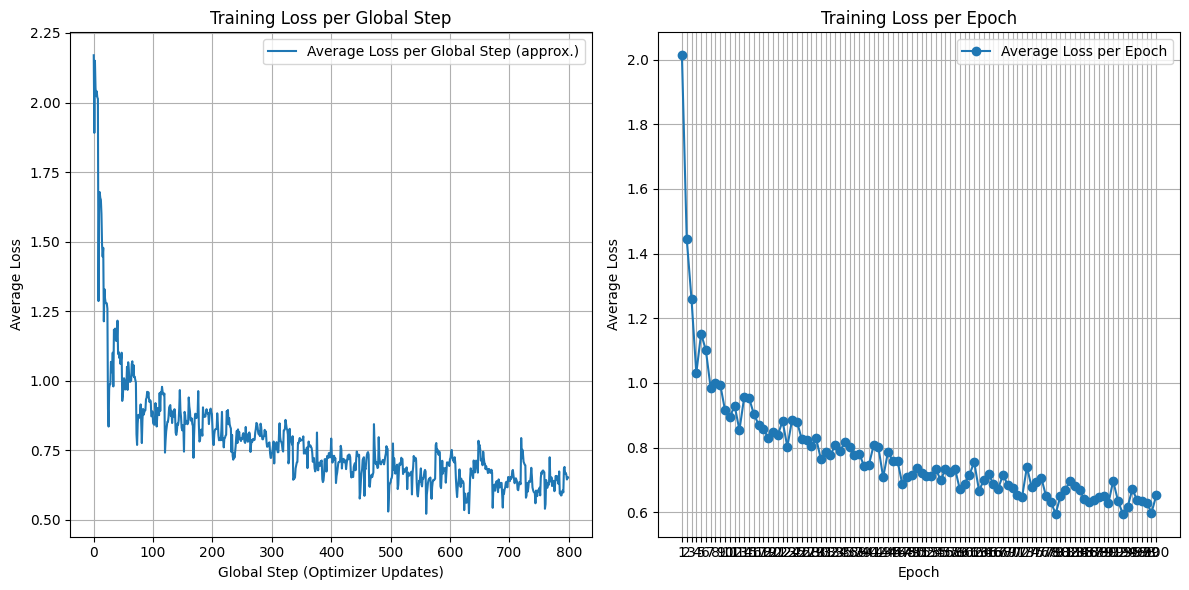

In [7]:
# 새로운 셀: 학습 Loss 그래프 시각화

import matplotlib.pyplot as plt
import numpy as np

# 이전 셀에서 all_step_losses 와 all_epoch_avg_losses 리스트가 생성되었다고 가정

if 'all_step_losses' in globals() and all_step_losses:
    plt.figure(figsize=(12, 6))
    
    # 스텝별 Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(all_step_losses, label='Average Loss per Global Step (approx.)')
    plt.xlabel('Global Step (Optimizer Updates)')
    plt.ylabel('Average Loss')
    plt.title('Training Loss per Global Step')
    plt.legend()
    plt.grid(True)
    
    if 'all_epoch_avg_losses' in globals() and all_epoch_avg_losses:
        # 에폭별 평균 Loss 그래프
        plt.subplot(1, 2, 2)
        # x축을 epoch 번호로 (1부터 시작)
        epochs = np.arange(1, len(all_epoch_avg_losses) + 1)
        plt.plot(epochs, all_epoch_avg_losses, label='Average Loss per Epoch', marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.title('Training Loss per Epoch')
        plt.xticks(epochs) # x축 눈금을 정수 에폭 번호로
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout() # 그래프들이 겹치지 않도록 레이아웃 조정
    plt.show()
else:
    print("기록된 Loss 데이터(all_step_losses)가 없습니다. 학습을 먼저 실행해주세요.")

In [8]:
# 새로운 셀: 저장된 체크포인트 모델을 사용한 Infilling 추론

import torch
import pandas as pd
import os
from transformers import GPT2TokenizerFast # 명시적으로 임포트
import sampling # sampling.py 임포트
from model import SEDD # SEDD 클래스 임포트
from omegaconf import OmegaConf # OmegaConf 임포트
# from load_model import load_model as load_model_util # 필요시 config 로드용

# --- 설정값 ---
MODEL_CHECKPOINT_DIR = '100epoch_finetuned_sedd_model' # 학습된 모델이 저장된 디렉토리
# 로드할 체크포인트 파일명 (예: 'model_epoch_20.pt' 또는 'model_step_XXX.pt')
CHECKPOINT_FILENAME = 'model_epoch_100.pt' 
DEVICE_INFER = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_SEQ_LENGTH_INFER = 1024 # 학습 시 사용한 MAX_SEQ_LENGTH와 동일하게 설정
DATA_FILE_PATH_FOR_INFERENCE_PREFIX = 'sampledata/processed_dataset.csv' # Prefix 가져올 데이터 파일

# --- 토크나이저 로드 (저장된 것 사용) ---
try:
    tokenizer_infer = GPT2TokenizerFast.from_pretrained(MODEL_CHECKPOINT_DIR)
    print(f"저장된 토크나이저 로드 완료: {MODEL_CHECKPOINT_DIR}")
    SEP_TOKEN_INFER = tokenizer_infer.eos_token
    print(f"추론 시 사용할 SEP_TOKEN: '{SEP_TOKEN_INFER}'")
except Exception as e:
    print(f"저장된 토크나이저 로드 실패: {e}. 기본 GPT-2 토크나이저를 사용합니다.")
    tokenizer_infer = GPT2TokenizerFast.from_pretrained('gpt2')
    if tokenizer_infer.pad_token is None: tokenizer_infer.pad_token = tokenizer_infer.eos_token
    SEP_TOKEN_INFER = tokenizer_infer.eos_token


# --- 모델 구조를 위한 Config 로드 ---
# SEDD 모델을 인스턴스화하려면 config 객체가 필요합니다.
# 가장 간단한 방법은 사전학습 모델("louaaron/sedd-small")의 config를 사용하는 것입니다.
# 또는 학습 시 사용했던 config를 저장해두었다가 로드할 수도 있습니다.
# 여기서는 louaaron/sedd-small의 config를 가져와서 사용합니다.

# 임시로 모델을 로드하여 config만 가져오기 (메모리 효율을 위해 바로 삭제)
# 만약 학습 셀에서 graph, noise 객체가 살아있다면 그것을 사용해도 됩니다.
try:
    from load_model import load_model as load_model_internal # 이름 충돌 피하기
    temp_model_for_config, graph_infer, noise_infer = load_model_internal("louaaron/sedd-small", DEVICE_INFER)
    model_config_infer = temp_model_for_config.config # OmegaConf 객체
    del temp_model_for_config # 메모리에서 즉시 해제
    print("추론을 위한 모델 config 로드 완료.")
except Exception as e:
    print(f"모델 config 로드 실패: {e}. 추론 진행이 어려울 수 있습니다.")
    model_config_infer, graph_infer, noise_infer = None, None, None


# --- 저장된 모델 로드 ---
if model_config_infer:
    inference_model = SEDD(model_config_infer) # config를 사용하여 모델 인스턴스 생성
    checkpoint_path = os.path.join(MODEL_CHECKPOINT_DIR, CHECKPOINT_FILENAME)
    try:
        inference_model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE_INFER))
        inference_model.to(DEVICE_INFER)
        inference_model.eval() # 추론 모드로 설정
        print(f"체크포인트 모델 로드 완료: {checkpoint_path}")
    except FileNotFoundError:
        print(f"오류: 체크포인트 파일을 찾을 수 없습니다 - {checkpoint_path}")
        inference_model = None
    except Exception as e:
        print(f"체크포인트 모델 로드 중 오류 발생: {e}")
        inference_model = None
else:
    inference_model = None

# --- Infilling 추론 실행 ---
if inference_model and tokenizer_infer and graph_infer and noise_infer:
    try:
        df_infer_prefix_source = pd.read_csv(DATA_FILE_PATH_FOR_INFERENCE_PREFIX)
        if not df_infer_prefix_source.empty:
            # 추론할 conditioning 텍스트 (예시로 첫 번째 데이터 사용)
            example_conditioning_text_infer = str(df_infer_prefix_source.iloc[0]['conditioning'])
            prefix_text_for_inference_infer = example_conditioning_text_infer + SEP_TOKEN_INFER
            
            print(f"\n추론 Prefix (일부): '{prefix_text_for_inference_infer[:150]}...'")

            prefix_ids_infer_list = tokenizer_infer.encode(prefix_text_for_inference_infer, add_special_tokens=False)
            num_prefix_tokens_infer = len(prefix_ids_infer_list)
            print(f"실제 Prefix 토큰 길이: {num_prefix_tokens_infer}")

            inference_total_sequence_length_infer = MAX_SEQ_LENGTH_INFER
            
            if num_prefix_tokens_infer >= inference_total_sequence_length_infer:
                print(f"오류: Prefix 토큰 길이({num_prefix_tokens_infer})가 전체 추론 시퀀스 길이({inference_total_sequence_length_infer})보다 크거나 같습니다.")
            else:
                max_order_tokens_to_generate_infer = inference_total_sequence_length_infer - num_prefix_tokens_infer
                print(f"모델이 생성할 Order 부분의 최대 토큰 길이: {max_order_tokens_to_generate_infer}")

                num_inference_samples_infer = 1
                sampling_steps_infer = 128 
                sampling_eps_infer = 1e-5

                prefix_ids_tensor_infer = torch.tensor(prefix_ids_infer_list, device=DEVICE_INFER).unsqueeze(0).expand(num_inference_samples_infer, -1)

                def infilling_proj_fun_infer(x_t_sampled):
                    x_t_sampled[:, :num_prefix_tokens_infer] = prefix_ids_tensor_infer
                    return x_t_sampled
                
                try:
                    if hasattr(inference_model, 'config') and inference_model.config and hasattr(inference_model.config, 'sampling'):
                         predictor_type_infer_detail = inference_model.config.sampling.predictor
                         denoise_sampling_infer_detail = inference_model.config.sampling.noise_removal
                    else: 
                        print("Warning: 로드된 모델 config에 sampling 정보가 없거나 config 객체 자체가 없습니다. 기본 샘플링 파라미터를 사용합니다.")
                        predictor_type_infer_detail = 'euler'
                        denoise_sampling_infer_detail = True
                    
                    current_inference_sampling_fn = sampling.get_pc_sampler(
                        graph=graph_infer, # graph, noise도 device로 전달 확인
                        noise=noise_infer.to(DEVICE_INFER),
                        batch_dims=(num_inference_samples_infer, inference_total_sequence_length_infer),
                        predictor=predictor_type_infer_detail,
                        steps=sampling_steps_infer,
                        denoise=denoise_sampling_infer_detail,
                        eps=sampling_eps_infer,
                        device=DEVICE_INFER,
                        proj_fun=infilling_proj_fun_infer
                    )
                    print("추론 샘플링 함수 준비 완료.")

                    with torch.no_grad():
                        generated_ids_for_inference = current_inference_sampling_fn(inference_model)
                        generated_ids_for_inference = infilling_proj_fun_infer(generated_ids_for_inference) 

                    print("\n--- 생성된 생산 계획 (Order 부분) ---")
                    for i, full_ids in enumerate(generated_ids_for_inference):
                        order_part_ids_infer = full_ids[num_prefix_tokens_infer:]
                        order_part_text_infer = tokenizer_infer.decode(order_part_ids_infer, skip_special_tokens=True)
                        print(f"\n--- 추론 샘플 {i+1} (생성된 Order 부분) ---")
                        print(order_part_text_infer.strip())
                        print("-" * 70)
                except Exception as e_samp:
                    print(f"추론 샘플링 중 오류 발생: {e_samp}")
                    import traceback
                    traceback.print_exc()
        else:
            print(f"Prefix를 가져올 데이터 파일({DATA_FILE_PATH_FOR_INFERENCE_PREFIX})이 비어있습니다.")
    except FileNotFoundError:
        print(f"Prefix를 가져올 데이터 파일을 찾을 수 없습니다: {DATA_FILE_PATH_FOR_INFERENCE_PREFIX}")
    except Exception as e_outer:
        print(f"추론 준비 중 오류 발생: {e_outer}")
        import traceback
        traceback.print_exc()
else:
    print("오류: 추론을 위한 모델, 토크나이저, 그래프 또는 노이즈 객체 로드에 실패했습니다.")

저장된 토크나이저 로드 완료: 100epoch_finetuned_sedd_model
추론 시 사용할 SEP_TOKEN: '<|endoftext|>'
추론을 위한 모델 config 로드 완료.
체크포인트 모델 로드 완료: 100epoch_finetuned_sedd_model/model_epoch_100.pt

추론 Prefix (일부): 'Order information
• item15, right? 318? You can do it by May 13th, 2021, and the unit price is 25,870 won. Oh, and the inspection product.
• Oh, I jus...'
실제 Prefix 토큰 길이: 773
모델이 생성할 Order 부분의 최대 토큰 길이: 251
추론 샘플링 함수 준비 완료.

--- 생성된 생산 계획 (Order 부분) ---

--- 추론 샘플 1 (생성된 Order 부분) ---
• item87 machine03 date190 98
• item87 machine18 date190 6
• item87 machine19 date190 19
• item87 machine20 date190 86
• item87 machine32 date190 19
• item87 machine33 date190 19
• item96 machine33 date189 106
• item96 machine10 date189 11
• item96 machine10 date189 6
• item96 machine22 date189 11
• item96 machine22 date189 24
• item96 machine23 date189 9
• item96 machine28 date189 4
• item96 machine28 date189 23
• item96 machine29 date189 18
• item96 machine30 date189 18
• item96 machine34 date189 3
• item96 machine3

In [ ]:
"• item87 machine01 date169 17
• item87 machine03 date169 63
• item87 machine18 date169 21
• item87 machine20 date169 26
• item87 machine33 date169 41
• item96 machine08 date150 13
• item96 machine09 date150 13
• item96 machine10 date150 14
• item96 machine12 date150 17
• item96 machine14 date150 5
• item96 machine21 date150 9
• item96 machine22 date150 15
• item96 machine23 date150 12
• item96 machine28 date150 14
• item96 machine29 date150 5
• item96 machine30 date150 15
• item96 machine34 date150 13
• item96 machine35 date150 8
• item91 machine09 date154 4
• item91 machine10 date154 3
• item91 machine14 date154 1
• item91 machine21 date154 2
• item91 machine28 date154 1
• item91 machine29 date154 1
• item91 machine34 date154 1
• item91 machine35 date154 2
• item16 machine14 date144 35
• item16 machine22 date144 85
• item16 machine28 date144 160
• item16 machine30 date144 47
• item16 machine31 date144 21
• item16 machine35 date144 31
• item15 machine10 date133 55
• item15 machine12 date133 27
• item15 machine20 date133 79
• item15 machine28 date133 39
• item15 machine31 date133 31
• item15 machine33 date133 59
• item15 machine34 date133 26"